# 0- Import library

In [1]:
!pip install optuna
!pip install torchinfo

In [2]:
# Common
import os
import numpy as np
from glob import glob
from tqdm import tqdm
import shutil
import random

# Data Viz
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import cv2
import random
import skimage
from matplotlib import colors
import glob

# File & Data Processing
import pandas as pd
import zipfile
import re
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split

# Model
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_score, recall_score
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F
from timm.optim import Lookahead
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
import time
from torchvision import models

# 1- Introduction to dataset

## 1.1 - Download dataset

In [3]:
!gdown https://drive.google.com/uc?id=1BdyfKncng6qYDmFofnjOKFFAgTD9BSXq
!gdown https://drive.google.com/uc?id=1bHL_cNOjq5uWQs2j5B6cb4rWuc-AhBbS
!gdown https://drive.google.com/uc?id=1_567w2jf9FkQLjgVgBn3pzLgQ7Uwx1Re
!unzip -q train.zip
!unzip -q public_test.zip
!unzip -q private_test.zip

Downloading...
From (original): https://drive.google.com/uc?id=1BdyfKncng6qYDmFofnjOKFFAgTD9BSXq
From (redirected): https://drive.google.com/uc?id=1BdyfKncng6qYDmFofnjOKFFAgTD9BSXq&confirm=t&uuid=34f8da1e-2050-4e31-9c74-5ff02427f02d
To: /kaggle/working/private_test.zip
100%|█████████████████████████████████████████| 498M/498M [00:01<00:00, 277MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1bHL_cNOjq5uWQs2j5B6cb4rWuc-AhBbS
From (redirected): https://drive.google.com/uc?id=1bHL_cNOjq5uWQs2j5B6cb4rWuc-AhBbS&confirm=t&uuid=bca41d07-6b62-466c-a6ff-88223193bf23
To: /kaggle/working/public_test.zip
100%|█████████████████████████████████████████| 478M/478M [00:01<00:00, 263MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1_567w2jf9FkQLjgVgBn3pzLgQ7Uwx1Re
From (redirected): https://drive.google.com/uc?id=1_567w2jf9FkQLjgVgBn3pzLgQ7Uwx1Re&confirm=t&uuid=420ca8cf-988b-4119-b4dd-0c6d14358185
To: /kaggle/working/train.zip
100%|███████████████████████████████

## 1.2 - Read images

In [4]:
def show_images(list_image, type_of_dataset):
  plt.figure(figsize=(16,16))
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    image = cv2.imread(list_image[i])
    ax.imshow(image[:, :, ::-1].astype("uint8"))
    ax.set_title(list_image[i])
    ax.axis("off")
  plt.suptitle(f"Read some image from {type_of_dataset} dataset")
  plt.show()

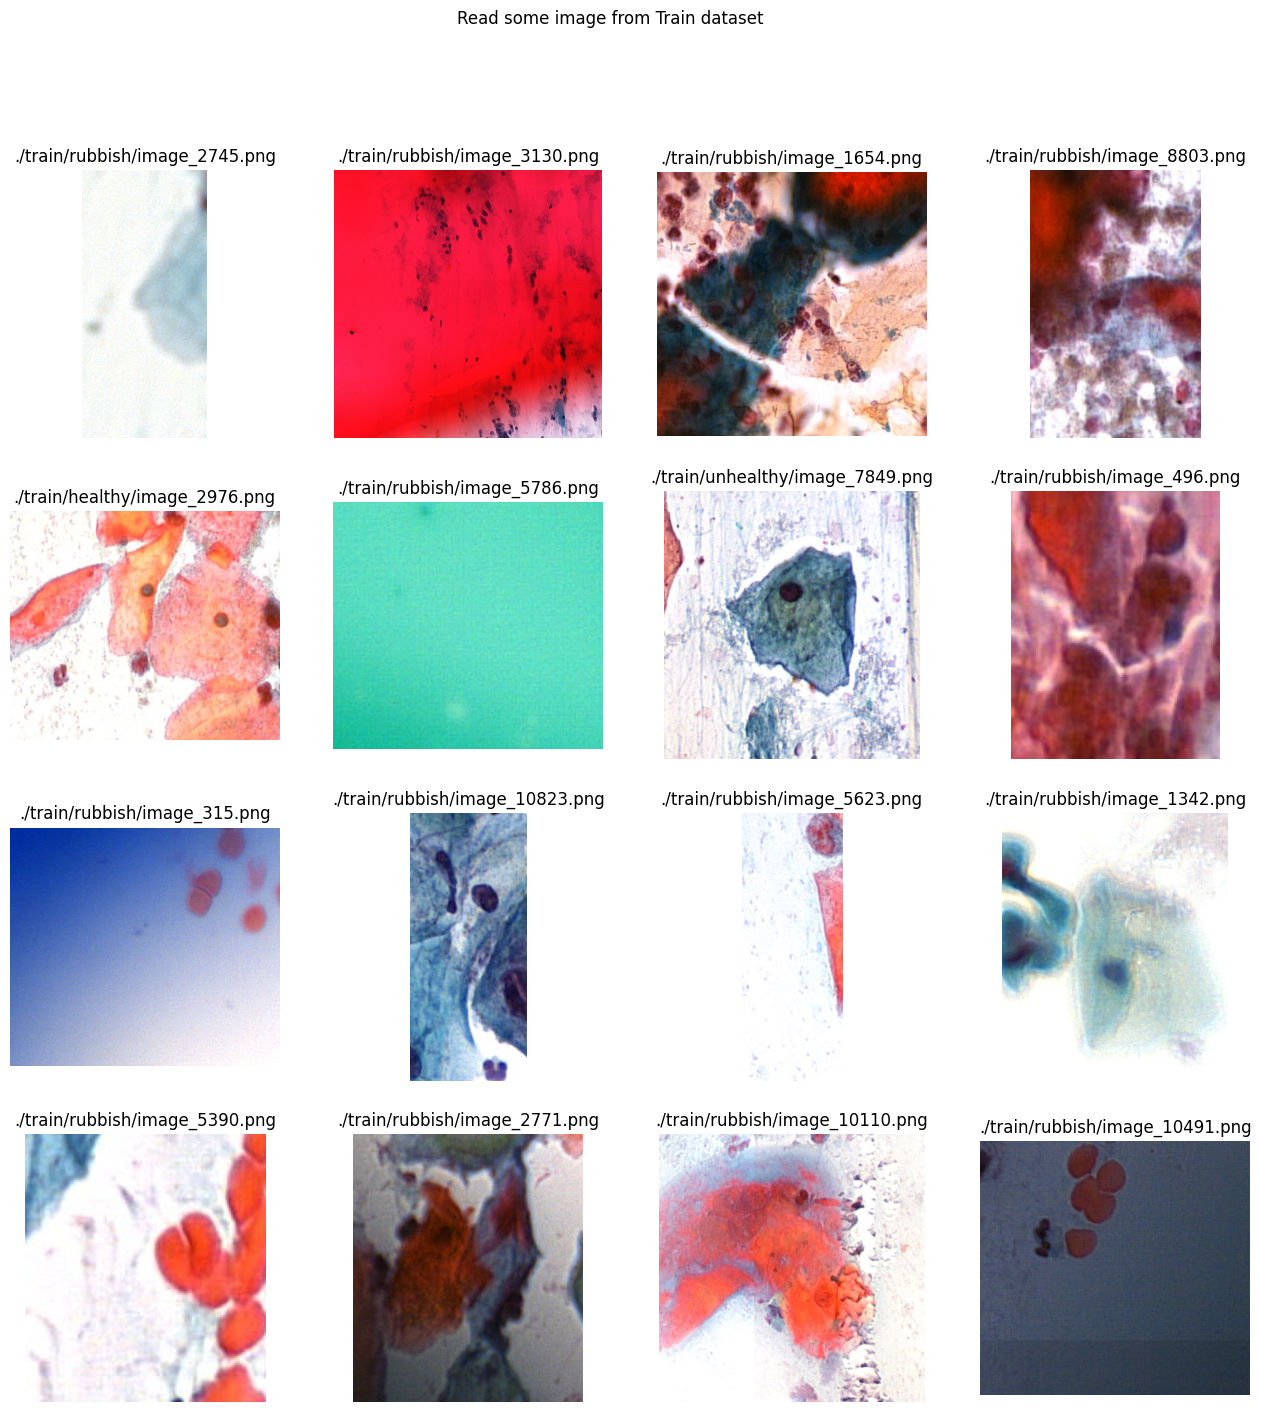

In [5]:
# Get some random image files in train dataset
list_image_files_train = glob.glob("./train/*/*.png")
random_images = random.sample(list_image_files_train, min(16, len(list_image_files_train)))
show_images(random_images, "Train")

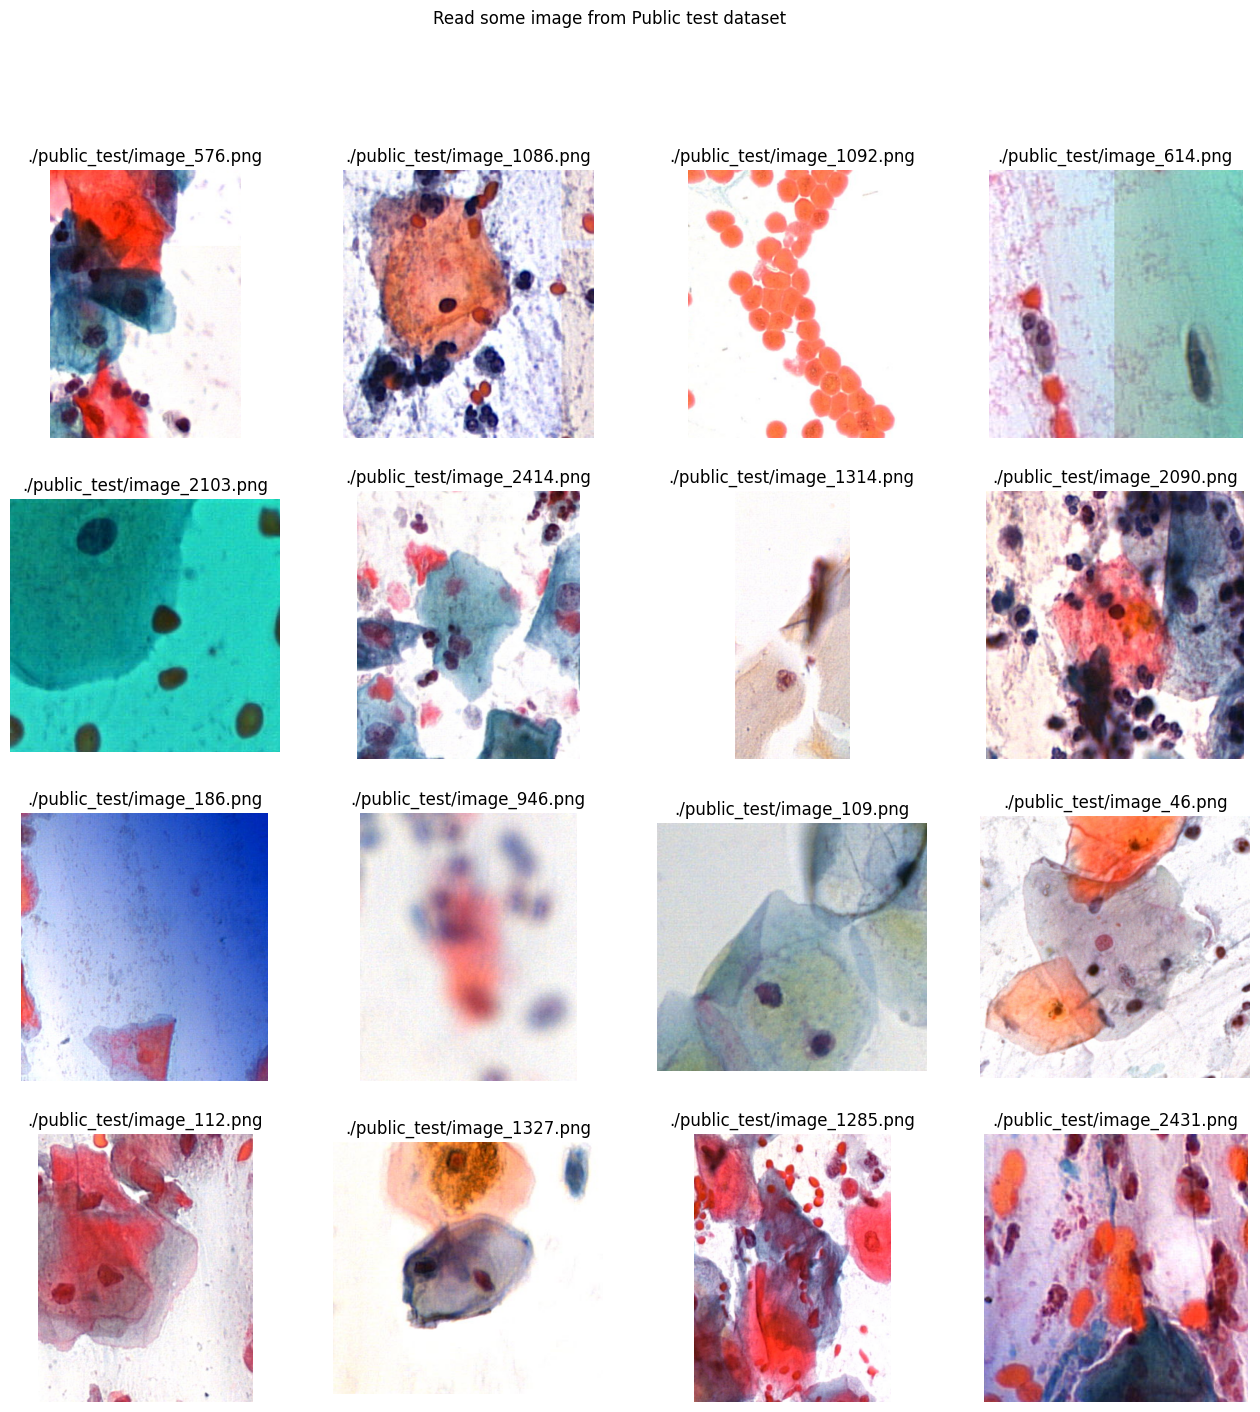

In [6]:
# Get some random image files in Public test dataset
list_image_files_public_test = glob.glob("./public_test/*.png")
random_images = random.sample(list_image_files_public_test, min(16, len(list_image_files_public_test)))
show_images(random_images, "Public test")

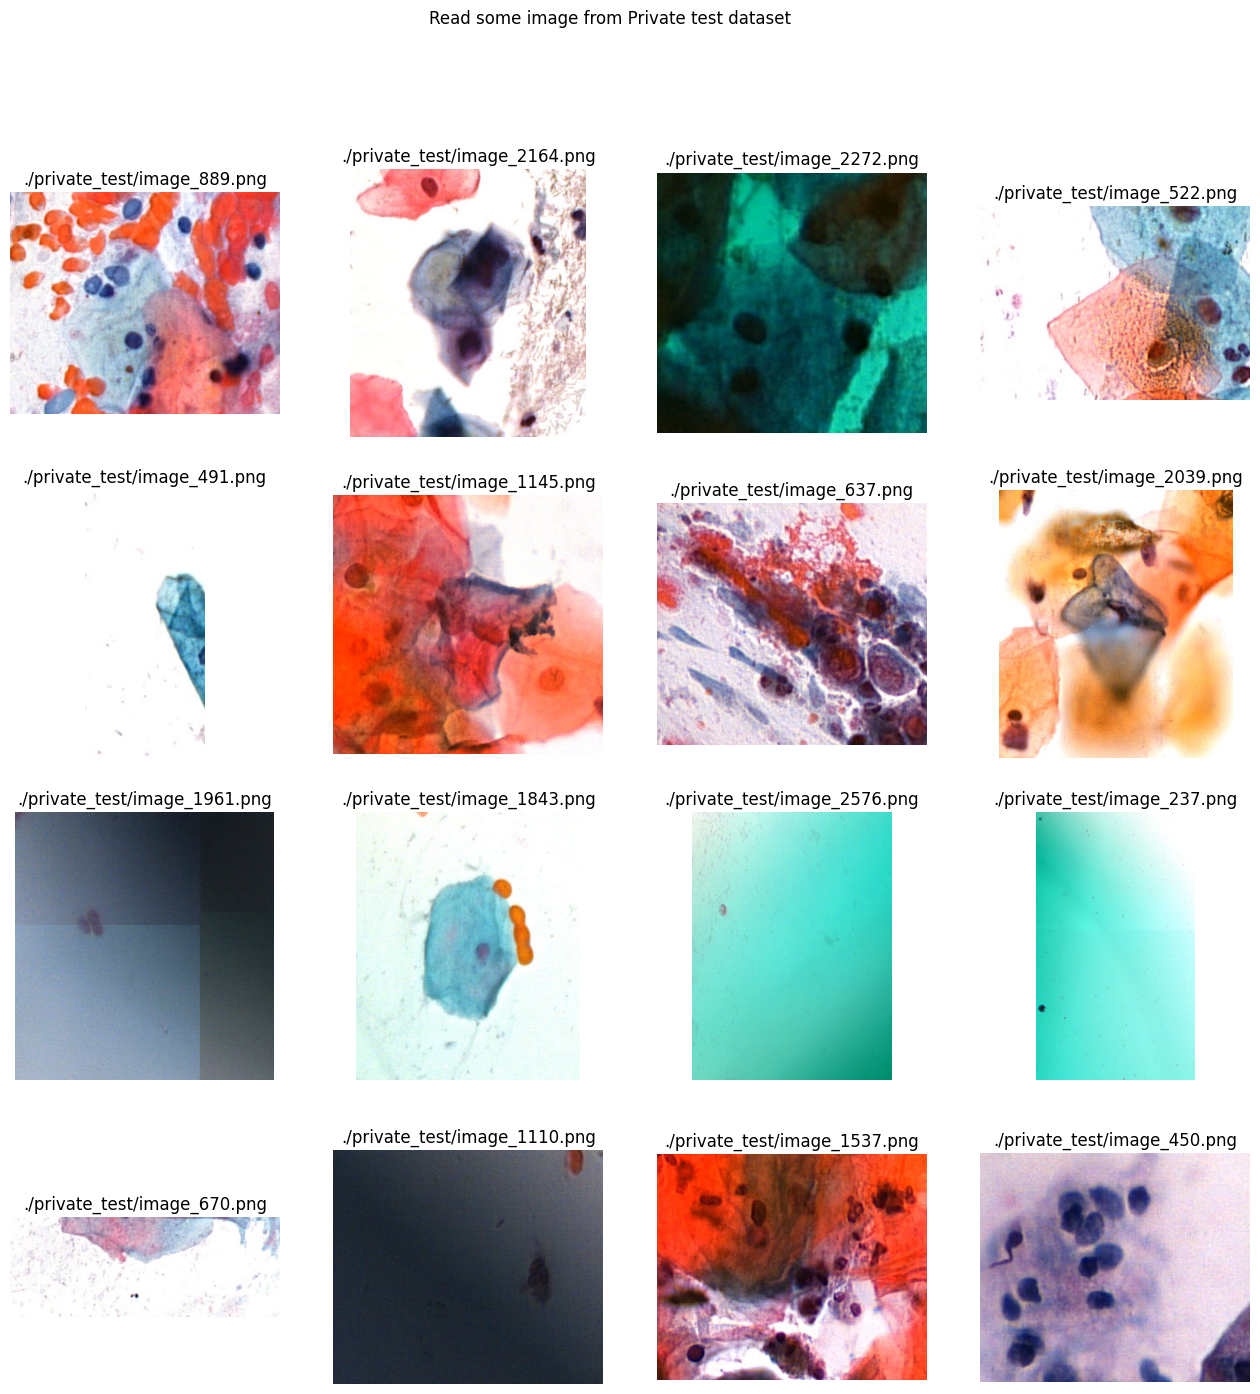

In [7]:
# Get some random image files in Private test dataset
list_image_files_private_test = glob.glob("./private_test/*.png")
random_images = random.sample(list_image_files_private_test, min(16, len(list_image_files_private_test)))
show_images(random_images, "Private test")

# 2- Basic information

## 2.1- Number of class names

In [8]:
list_class_train = [f.name for f in os.scandir('./train') if f.is_dir()]
print(f"Class Names in Train dataset: \n{list_class_train}")
print(f"Total Number of Classes in Train dataset: {len(list_class_train)}")

Class Names in Train dataset: 
['healthy', 'unhealthy', 'rubbish']
Total Number of Classes in Train dataset: 3


## 2.2- Total number of images in each type of dataset

In [9]:
print(f"Total number of images in Train dataset: {len(list_image_files_train)}")
print(f"Total number of images in Public Test dataset: {len(list_image_files_public_test)}")
print(f"Total number of images in Private Test dataset: {len(list_image_files_private_test)}")

Total number of images in Train dataset: 12599
Total number of images in Public Test dataset: 2699
Total number of images in Private Test dataset: 2702


## 2.3- Make table of all type of data

In [10]:
list_train_information = {"image_path": [] , "label": [] }
for c_names in list_class_train:
  class_path = os.path.join('./train', c_names)
  list_train_information["image_path"].extend([os.path.join(class_path, file) for file in os.listdir(class_path)])
  list_train_information["label"].extend([c_names] * len(os.listdir(class_path)))

train_dataset = pd.DataFrame(list_train_information, index = range(len(list_train_information['image_path']))).sample(frac = 1, random_state = 0).reset_index()
train_dataset

index                        image_path      label
0       8161    ./train/rubbish/image_1674.png    rubbish
1       2535   ./train/healthy/image_12328.png    healthy
2       5119  ./train/unhealthy/image_8646.png  unhealthy
3      11051    ./train/rubbish/image_6283.png    rubbish
4      12517    ./train/rubbish/image_5332.png    rubbish
...      ...                               ...        ...
12594   4859  ./train/unhealthy/image_9094.png  unhealthy
12595   3264     ./train/healthy/image_803.png    healthy
12596   9845    ./train/rubbish/image_5285.png    rubbish
12597  10799    ./train/rubbish/image_1047.png    rubbish
12598   2732    ./train/healthy/image_2973.png    healthy

[12599 rows x 3 columns]

In [11]:
list_public_test_information = {"image_path": []}
for image in os.listdir('./public_test'):
  list_public_test_information["image_path"].append(os.path.join('./public_test', image))

public_test_dataset = pd.DataFrame(list_public_test_information, index = range(len(list_public_test_information['image_path'])))
public_test_dataset

image_path
0     ./public_test/image_1092.png
1     ./public_test/image_1124.png
2     ./public_test/image_2263.png
3     ./public_test/image_2474.png
4      ./public_test/image_696.png
...                            ...
2694  ./public_test/image_1513.png
2695  ./public_test/image_1585.png
2696  ./public_test/image_1942.png
2697  ./public_test/image_2227.png
2698  ./public_test/image_2443.png

[2699 rows x 1 columns]

In [12]:
list_private_test_information = {"image_path": []}
for image in os.listdir('./private_test'):
  list_private_test_information["image_path"].append(os.path.join('./private_test', image))

private_test_dataset = pd.DataFrame(list_private_test_information, index = range(len(list_private_test_information['image_path'])))
private_test_dataset

image_path
0     ./private_test/image_1092.png
1     ./private_test/image_1124.png
2     ./private_test/image_2263.png
3     ./private_test/image_2474.png
4      ./private_test/image_696.png
...                             ...
2697  ./private_test/image_1513.png
2698  ./private_test/image_1585.png
2699  ./private_test/image_1942.png
2700  ./private_test/image_2227.png
2701  ./private_test/image_2443.png

[2702 rows x 1 columns]

## 2.4- Check size of image of each set

In [13]:
# train_dataset["size"] = train_dataset["image_path"].apply(lambda image: cv2.imread(image).shape)
# size_value, size_count = np.unique(train_dataset["size"], return_counts = True)
# print(f"List size of all images in Train dataset")
# for size_information in zip(size_value, size_count):
#   print(f"{size_information[0]}:    {size_information[1]} images")

# public_test_dataset["size"] = public_test_dataset["image_path"].apply(lambda image: cv2.imread(image).shape)
# size_value, size_count = np.unique(public_test_dataset["size"], return_counts = True)
# print(f"List size of all images in Public test dataset")
# for size_information in zip(size_value, size_count):
#   print(f"{size_information[0]}:    {size_information[1]} images")

# private_test_dataset["size"] = private_test_dataset["image_path"].apply(lambda image: cv2.imread(image).shape)
# size_value, size_count = np.unique(private_test_dataset["size"], return_counts = True)
# print(f"List size of all images in Private test dataset")
# for size_information in zip(size_value, size_count):
#   print(f"{size_information[0]}:    {size_information[1]} images")

# 3- Visualization

## 3.1- Class distribution in Train dataset

In [14]:
fig = px.pie(names = ["Healthy", "Unhealthy", "Rubbish"], values = [len(os.listdir('train/healthy')), len(os.listdir('train/unhealthy')), len(os.listdir('train/rubbish'))], width=800)
fig.update_layout({"title":{'text':f"Class Distribution of Train dataset","x":0.5}})
fig.show()

## 3.2- File size distribution in each type of dataset

In [15]:
train_dataset["file_size"] = train_dataset["image_path"].apply(lambda image: os.path.getsize(image) / 1_000_000)

fig = px.histogram(x = train_dataset["file_size"], nbins = 50, title = f"Distribution of file sizes in Train dataset")

fig.update_layout(
    xaxis_title = "File Size (MB)",
    yaxis_title = "Number of Images",
    showlegend = False,
    bargap = 0.1,
    bargroupgap = 0.1
)

fig.show()

In [16]:
public_test_dataset["file_size"] = public_test_dataset["image_path"].apply(lambda image: os.path.getsize(image) / 1_000_000)

fig = px.histogram(x = public_test_dataset["file_size"], nbins = 50, title = f"Distribution of file sizes in Public test dataset")

fig.update_layout(
    xaxis_title = "File Size (MB)",
    yaxis_title = "Number of Images",
    showlegend = False,
    bargap = 0.1,
    bargroupgap = 0.1
)

fig.show()

In [17]:
private_test_dataset["file_size"] = private_test_dataset["image_path"].apply(lambda image: os.path.getsize(image) / 1_000_000)

fig = px.histogram(x = private_test_dataset["file_size"], nbins = 50, title = f"Distribution of file sizes in Private test dataset")

fig.update_layout(
    xaxis_title = "File Size (MB)",
    yaxis_title = "Number of Images",
    showlegend = False,
    bargap = 0.1,
    bargroupgap = 0.1
)

fig.show()

# 4- Models

## 4.0- Setup hyperparams

In [18]:
SUBMISSION_MODE = 0 # 0: Not submit, 1: Public dataset, 2: Private dataset
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [19]:
random.seed(0)
np.random.seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 4.1- Split data

In [20]:
# Transformation pipeline
transform = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.RandomAffine(degrees=0, shear=15, scale=(0.8, 1.2)),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [21]:
class LabeledDataset(Dataset):
    def __init__(self, data, transform=None, balance_classes=False, oversample_minority=False):
        # Read Dataframe contain information in Train dataset
        self.data = data
        self.transform = transform
        self.balance_classes = balance_classes
        self.oversample_minority = oversample_minority

        # Define class-to-index mapping
        self.class_to_idx = {'rubbish': 0, 'unhealthy': 1, 'healthy': 2}

        # Balance classes
        if self.balance_classes:
            self._balance_classes()

        # Oversample minority class
        if self.oversample_minority:
            self._oversample_minority()

    def _balance_classes(self):
        """Balances the dataset by reducing the number of 'rubbish' samples to match 'healthy' samples."""
        healthy_count = self.data[self.data['label'] == 'healthy'].shape[0]
        rubbish_count = self.data[self.data['label'] == 'rubbish'].shape[0]

        if rubbish_count > healthy_count:
            # Reduce the number of 'rubbish' samples to match 'healthy' samples
            rubbish_samples = self.data[self.data['label'] == 'rubbish']
            rubbish_samples = rubbish_samples.sample(n=healthy_count, random_state=42)
            other_samples = self.data[self.data['label'] != 'rubbish']
            self.data = pd.concat([other_samples, rubbish_samples]).reset_index(drop=True)

    def _oversample_minority(self):
        """Oversamples the minority class by applying additional transformations."""
        # Determine the minority class
        label = self.data['label']
        class_counts = Counter(label)

        # Get the minority and majority classes
        minority_class, minority_count = min(class_counts.items(), key=lambda x: x[1])
        majority_class, majority_count = max(class_counts.items(), key=lambda x: x[1])

        # Calculate the number of additional samples needed
        additional_samples_needed = majority_count - minority_count

        # Get the minority class samples as a DataFrame
        minority_samples = self.data[self.data['label'] == minority_class]

        # Debugging: Check the type of minority_samples
        if not isinstance(minority_samples, pd.DataFrame):
            print(f"[WARNING] minority_samples is not a DataFrame. Type: {type(minority_samples)}")
            minority_samples = pd.DataFrame(minority_samples)

        # Apply additional transformations to create new samples
        augmented_samples = []
        for _ in range(additional_samples_needed):
            sample = minority_samples.sample(n=1, random_state=random.randint(0, 1000))
            augmented_samples.append(sample)

        # Concatenate the original data with the augmented samples
        self.data = pd.concat([self.data] + augmented_samples).reset_index(drop=True)
        print(f"Data after oversampling minority class: {self.data.shape}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]  # Image file name
        label = self.data.iloc[idx, 2]  # Image label

        if not os.path.exists(img_path):
            print(f"[WARNING] Missing image: {img_path}. Replacing with a random {label} image.")

            # Select a random replacement image from the same class
            same_class_images = self.data[self.data['label'] == label]['image_name'].tolist()
            if same_class_images:
                img_path = random.choice(same_class_images)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = self.class_to_idx[label]

        return image, label

# Class for unlabeled test data
class UnlabeledDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image name from the CSV file
        img_path = self.data.iloc[idx, 1]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
            # print(f"Image {img_path} shape: {image.shape}")

        return image, img_path

In [22]:
# Load full dataset
train_dataset, val_dataset = train_test_split(
    train_dataset,
    test_size = 0.1,
    random_state = 42,
    stratify = train_dataset['label']  # Ensures the label distribution is preserved
)

if (SUBMISSION_MODE == 0):
  train_dataset, test_dataset = train_test_split(
      train_dataset,
      test_size = 0.1,
      random_state = 42,
      stratify = train_dataset['label']  # Ensures the label distribution is preserved
  )
if (SUBMISSION_MODE == 1):
  test_dataset = public_test_dataset
if (SUBMISSION_MODE == 2):
  test_dataset = private_test_dataset

print(f"Found {len(train_dataset)} train image filenames belonging to {len(set(train_dataset['label']))} classes.")
print(f"Found {len(val_dataset)} validation image filenames belonging to {len(set(val_dataset['label']))} classes.")
print(f"Found {len(test_dataset)} test image filenames belonging to {len(set(test_dataset['label']))} classes.")

Found 10205 train image filenames belonging to 3 classes.
Found 1260 validation image filenames belonging to 3 classes.
Found 1134 test image filenames belonging to 3 classes.


In [23]:
train_data = LabeledDataset(train_dataset, transform['train'], balance_classes=False, oversample_minority=False)
val_data = LabeledDataset(val_dataset, transform['val'], balance_classes=False, oversample_minority=False)
if (SUBMISSION_MODE == 0):
    test_data = LabeledDataset(val_dataset, transform['test'], balance_classes=False, oversample_minority=False)
else:
    test_data = UnlabeledDataset(test_dataset, transform['test'])

In [24]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)
val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)

## 4.2- Helper function

In [25]:
def calculate_class_weights(dataset):
  if isinstance(dataset, LabeledDataset):
      labels = dataset.data['label'].tolist()
  else:
      labels = [dataset.dataset.data.iloc[idx, 2] for idx in dataset.indices]

  class_counts = Counter(labels)
  total_samples = sum(class_counts.values())
  class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

  weight_sum = sum(class_weights.values())
  class_weights = {cls: weight / weight_sum for cls, weight in class_weights.items()}

  if isinstance(dataset, LabeledDataset):
      idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
  else:
      idx_to_class = {v: k for k, v in dataset.dataset.class_to_idx.items()}

  weights = [class_weights[idx_to_class[idx]] for idx in sorted(idx_to_class.keys())]

  return torch.tensor(weights, dtype=torch.float32)

In [26]:
class EarlyStopping:
  def __init__(self, patience=5, delta=0.0, verbose=False, save_dir='artifacts', model_name='best_model.pth'):
      """
      Early stopping to stop training if validation loss doesn't improve.

      Args:
          patience (int): Number of epochs to wait for improvement.
          delta (float): Minimum change to qualify as an improvement.
          verbose (bool): Whether to print messages when stopping early.
          save_dir (str): Directory to save the best model checkpoint.
          model_name (str): Name of the saved model file.
      """
      self.patience = patience
      self.delta = delta
      self.verbose = verbose
      self.counter = 0
      self.best_loss = np.inf
      self.early_stop = False
      self.val_loss_min = np.inf

      # Create the save directory if it doesn't exist
      self.save_dir = save_dir
      os.makedirs(self.save_dir, exist_ok=True)

      # Define the path for saving the model
      self.path = os.path.join(self.save_dir, model_name)

  def __call__(self, val_loss, model):
      """
      Check if the validation loss has improved and save the model if needed.

      Args:
          val_loss (float): The current validation loss.
          model (torch.nn.Module): The model to save if validation loss improves.
      """
      if val_loss < self.best_loss - self.delta:
          self.best_loss = val_loss
          self.counter = 0
          if self.verbose:
              print(f'Validation loss decreased: {self.val_loss_min:.6f} --> {val_loss:.6f}. Saving model...')
          torch.save(model.state_dict(), self.path)  # Save the model
      else:
          self.counter += 1
          if self.verbose:
              print(f'Validation loss did not improve: {val_loss:.6f}. Patience counter: {self.counter}/{self.patience}')
          if self.counter >= self.patience:
              self.early_stop = True
              print("Early stopping triggered.")

In [27]:
def save_checkpoint(model, optimizer, epoch, loss, save_path, save_path_best, is_best=False):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, save_path)
    if is_best:
        torch.save(checkpoint, save_path_best)

## 4.3- Loss function

As the unhealthy class has a very small number of samples compared to the other two classes, we used categorical weighted focal loss. In this first experiment, the alpha parameter is equal for all three classes: $0.25$. This helped us understand the effect of changing alpha values in the subsequent experiments and how this affected the model's performance. To improve the robustness and generalization ability of the models in my ensemble, we applied `FocalLossWithLabelSmoothing`. This technique helped address class imbalance, reduced overfitting, and ensured that the models didn't become too overconfident in their predictions, leading to more reliable and diverse models. The combination of focal loss and label smoothing also encouraged the individual models to focus on difficult examples, which enhanced the overall performance when combined in an ensemble. We would like top clarify an important point: in the final test phase we used ensemble model to enhance the predictions. The decision of which models to ensemble was based on studying the results of the confusion matrix on the test data "10% of the training data"; It was not arbitray.

In [28]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

class FocalLossWithLabelSmoothing(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, smoothing=0.1):
        super(FocalLossWithLabelSmoothing, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smoothing = smoothing

    def forward(self, inputs, targets):
        targets = F.one_hot(targets, num_classes=inputs.size(1)).float()
        targets = targets * (1 - self.smoothing) + self.smoothing / inputs.size(1)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

class FocalLossWithClassWeights(nn.Module):
    def __init__(self, class_alpha=[0.25, 0.25, 0.75], gamma=2.0, smoothing=0.1):
        """
        class_alpha: List containing alpha values for each class
        gamma: Focusing parameter for Focal Loss
        smoothing: Label smoothing factor
        """
        super(FocalLossWithClassWeights, self).__init__()
        self.class_alpha = torch.tensor(class_alpha).to(device)  # Convert to tensor and send to device
        self.gamma = gamma
        self.smoothing = smoothing

    def forward(self, inputs, targets):
        targets = F.one_hot(targets, num_classes=inputs.size(1)).float()
        targets = targets * (1 - self.smoothing) + self.smoothing / inputs.size(1)

        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)

        alpha_weights = self.class_alpha[targets.argmax(dim=1)]
        focal_loss = alpha_weights * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

## 4.4- Training and testing functions

In [29]:
def train(model, num_epoches, train_loader, val_loader, save_path, save_path_best):
  # Training loop
    best_val_f1 = 0.0
    for epoch in range(num_epoches):
        model.train()
        train_loss, train_correct, train_preds, train_targets = 0, 0, [], []
        train_label_counts = np.zeros(3, dtype=int)

        # Wrap train_loader with tqdm for progress bar
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epoches} [Train]",
                       leave=False, ncols=100, dynamic_ncols=True)
        for images, labels in train_progress:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update the learning rate schedule
            if scheduler:
                scheduler.step()

            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())
            train_loss += loss.item()
            for label in labels.cpu().numpy():
                train_label_counts[label] += 1

            # Update progress bar with current loss
            train_progress.set_postfix({"Loss": loss.item()})

        train_acc = 100 * train_correct / len(train_dataset)
        train_precision = precision_score(train_targets, train_preds, average='weighted')
        train_recall = recall_score(train_targets, train_preds, average='weighted')
        train_f1 = f1_score(train_targets, train_preds, average='weighted')

        # Validation phase
        model.eval()
        val_loss, val_correct, val_preds, val_targets = 0, 0, [], []
        val_label_counts = np.zeros(3, dtype=int)

        # Wrap val_loader with tqdm for progress bar
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epoches} [Val]",
                     leave=False, ncols=100, dynamic_ncols=True)
        with torch.no_grad():
            for images, labels in val_progress:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                val_loss += loss.item()
                for label in labels.cpu().numpy():
                    val_label_counts[label] += 1

                # Update progress bar with current loss
                val_progress.set_postfix({"Loss": loss.item()})

        val_acc = 100 * val_correct / len(val_dataset)
        val_precision = precision_score(val_targets, val_preds, average='weighted')
        val_recall = recall_score(val_targets, val_preds, average='weighted')
        val_f1 = f1_score(val_targets, val_preds, average='weighted')

        class_names = ['rubbish', 'unhealthy', 'healthy']

        # Generate class-wise F1 score report
        class_f1_report = classification_report(val_targets, val_preds, target_names=class_names)

        # Compute average F1 score from the classification report
        avg_f1_score = (val_f1)

        # Print to output the logs
        print(f"Epoch {epoch + 1}/{num_epoches} - Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")
        print(f"Train Accuracy: {train_acc:.2f}, Val Accuracy: {val_acc:.2f}")
        print(f"Train Precision: {train_precision:.2f}, Val Precision: {val_precision:.2f}")
        print(f"Train Recall: {train_recall:.2f}, Val Recall: {val_recall:.2f}")
        print(f"Train F1: {train_f1:.2f}, Val F1: {val_f1:.2f}")
        print(f"Class-wise F1-Scores:\n {class_f1_report}")
        print(f"Average F1-Score: {avg_f1_score:.4f}")

        # Save checkpoint based on the best F1-Score
        if avg_f1_score > best_val_f1:
            best_val_f1 = avg_f1_score
            save_checkpoint(model, optimizer, epoch, val_loss, save_path, save_path_best, is_best=True)

        # Early stopping based on F1-Score
        early_stopping(-avg_f1_score, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

In [30]:
def predict_labels(model, test_loader, device):
    """Predict labels for unlabeled data."""
    model.eval()
    image_names, all_preds = [], []

    with torch.no_grad():
        for images, img_names in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            image_names.extend(img_names)

    return image_names, all_preds

In [31]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss, test_correct, test_preds, test_targets = 0, 0, [], []

    with torch.no_grad():
        for batch in test_loader:
            if len(batch) == 2:
                images, labels = batch
                labels = labels.to(device)
            else:
                images = batch[0]
                labels = None

            images = images.to(device)
            outputs = model(images)

            if labels is not None:
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                test_correct += (predicted == labels).sum().item()
                test_preds.extend(predicted.cpu().numpy())
                test_targets.extend(labels.cpu().numpy())
            else:
                _, predicted = torch.max(outputs, 1)
                test_preds.extend(predicted.cpu().numpy())

    if labels is not None:
        test_acc = 100 * test_correct / len(test_loader.dataset)
        test_precision = precision_score(test_targets, test_preds, average='weighted')
        test_recall = recall_score(test_targets, test_preds, average='weighted')
        test_f1 = f1_score(test_targets, test_preds, average='weighted')

        class_names = ['rubbish', 'unhealthy', 'healthy']
        class_f1_report = classification_report(test_targets, test_preds, target_names=class_names)
        avg_f1_score = test_f1
        return test_loss / len(test_loader), test_acc, test_precision, test_recall, test_f1, class_f1_report, avg_f1_score
    else:
        return None, None, None, None, None, None, None

## 4.5- Models configuration

In [32]:
# Model mappings
model_mapping = {
    "densenet121": (
        models.densenet121,
        {"weights": models.DenseNet121_Weights.DEFAULT, "family": "densenet"},
    ),
    "densenet161": (
        models.densenet161,
        {"weights": models.DenseNet161_Weights.DEFAULT, "family": "densenet"},
    ),
    "densenet169": (
        models.densenet169,
        {"weights": models.DenseNet169_Weights.DEFAULT, "family": "densenet"},
    ),
    "densenet201": (
        models.densenet201,
        {"weights": models.DenseNet201_Weights.DEFAULT, "family": "densenet"},
    ),
    "resnet50": (
        models.resnet50,
        {"weights": models.ResNet50_Weights.IMAGENET1K_V2, "family": "resnet"},
    ),
    "resnet101": (
        models.resnet101,
        {"weights": models.ResNet101_Weights.IMAGENET1K_V2, "family": "resnet"},
    ),
    "resnet152": (
        models.resnet152,
        {"weights": models.ResNet152_Weights.IMAGENET1K_V2, "family": "resnet"},
    ),
    "vit-b-16": (
        models.vit_b_16,
        {"weights": models.ViT_B_16_Weights.DEFAULT, "family": "vit"},
    ),
    "vit-b-32": (
        models.vit_b_32,
        {"weights": models.ViT_B_32_Weights.DEFAULT, "family": "vit"},
    ),
    "convnext-b": (
        models.convnext_base,
        {"weights": models.ConvNeXt_Base_Weights.DEFAULT, "family": "convnext"},
    ),
    "swin-t": (
        models.swin_t,
        {"weights": models.Swin_T_Weights.DEFAULT, "family": "swin"},
    ),
    # Add more models as needed with their respective configurations.
}

class Model(nn.Module):
    """Model definition."""

    def __init__(self, model_name: str, num_classes: int):
        """
        Initialize Model instance.

        Args:
            model_name (str): Name of the model architecture.
            num_classes (int): Number of output classes.
        """
        super(Model, self).__init__()

        # Get model class and configuration
        model_class, model_config = model_mapping[model_name]
        self.model = model_class(weights=model_config["weights"])

        # Freeze model parameters
        for param in self.model.parameters():
            param.requires_grad = False

        # Get the in_features from the model family
        in_features = self._get_in_features(model_config["family"])

        # Adjust the classifier according to the model family
        if model_config["family"] == "densenet":
            self.model.classifier = self._create_classifier(in_features, num_classes)
        elif model_config["family"] == "resnet":
            self.model.fc = self._create_classifier(in_features, num_classes)
        elif model_config["family"] == "vit":
            self.model.heads = self._create_classifier(in_features, num_classes)
        elif model_config["family"] == "convnext":
            self.model.classifier[2] = self._create_classifier(in_features, num_classes)
        elif model_config["family"] == "swin":
            self.model.head = self._create_classifier(in_features, num_classes)


    def forward(self, x):
        """Forward pass through the model."""
        return self.model(x)

    def _get_in_features(self, family: str) -> int:
        """Return the number of input features for the classifier."""
        if family == "densenet":
            return self.model.classifier.in_features
        elif family == "resnet":
            return self.model.fc.in_features
        elif family == "vit":
            return self.model.heads.head.in_features
        elif family == "convnext":
            return self.model.classifier[2].in_features
        elif family == "swin":
            return self.model.head.in_features
        else:
            raise ValueError(f"Unknown model family: {family}")

    def _create_classifier(self, in_features: int, num_classes: int) -> nn.Sequential:
        """Create the classifier module."""
        return nn.Sequential(
            nn.Linear(in_features, in_features // 2),
            nn.ReLU(),
            nn.Dropout(0.1), # 0.5
            nn.Linear(in_features // 2, num_classes),
        )


class ModelFactory:
    """
    Factory for creating different models based on their names.
    """

    def __init__(self, model_name: str, num_classes: int):
        """
        Initialize ModelFactory instance.

        Args:
            model_name (str): The name of the model.
            num_classes (int): The number of output classes.
        """
        self.model_name = model_name
        self.num_classes = num_classes

    def __call__(self):
        """
        Create a model instance based on the provided name.

        Returns:
            Model: An instance of the selected model.
        """
        if self.model_name not in model_mapping:
            valid_options = ", ".join(model_mapping.keys())
            raise ValueError(
                f"Invalid model name: '{self.model_name}'. Available options: {valid_options}"
            )

        return Model(self.model_name, self.num_classes)

    def get_model(self):
        """Returns the created model directly."""
        return self()

## 4.6- ViT-B-16

In [33]:
MODEL_NAME = "vit-b-16"
LR = 5e-4
PATIENCE = 10
USE_SCHEDULER = True
NUM_EPOCHS = 100

In [34]:
# Load model
model_factory = ModelFactory(MODEL_NAME, 3)
model = model_factory.get_model().to(device)

# Summary model
summary(model = model,
        input_size=(8, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 189MB/s]  


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
Model (Model)                                                     [8, 3, 224, 224]     [8, 3]               --                   Partial
├─VisionTransformer (model)                                       [8, 3, 224, 224]     [8, 3]               768                  Partial
│    └─Conv2d (conv_proj)                                         [8, 3, 224, 224]     [8, 768, 14, 14]     (590,592)            False
│    └─Encoder (encoder)                                          [8, 197, 768]        [8, 197, 768]        151,296              False
│    │    └─Dropout (dropout)                                     [8, 197, 768]        [8, 197, 768]        --                   --
│    │    └─Sequential (layers)                                   [8, 197, 768]        [8, 197, 768]        (85,054,464)         False
│    │    └─LayerNorm (ln)                        

In [35]:
# Config some learning schedule
criterion = nn.CrossEntropyLoss(weight=calculate_class_weights(train_data).to(device))
# criterion = FocalLossWithClassWeights(class_alpha = [0.5, 1.0, 2.0])
base_optimizer = optim.AdamW(model.parameters(), lr=LR)
optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10) if USE_SCHEDULER else None
early_stopping = EarlyStopping(patience=PATIENCE, verbose=True)

In [36]:
# Training model
train(model, NUM_EPOCHS, train_loader, val_loader, f'./{MODEL_NAME}.h5',  f'./{MODEL_NAME}_best.h5')

Epoch 1/100 - Train Loss: 0.8429, Val Loss: 0.7745
Train Accuracy: 68.69, Val Accuracy: 71.35
Train Precision: 0.76, Val Precision: 0.78
Train Recall: 0.69, Val Recall: 0.71
Train F1: 0.72, Val F1: 0.74
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.91      0.76      0.83       746
   unhealthy       0.17      0.38      0.23        86
     healthy       0.67      0.69      0.68       428

    accuracy                           0.71      1260
   macro avg       0.58      0.61      0.58      1260
weighted avg       0.78      0.71      0.74      1260

Average F1-Score: 0.7402
Validation loss decreased: inf --> -0.740207. Saving model...


Epoch 2/100 - Train Loss: 0.7566, Val Loss: 0.7537
Train Accuracy: 71.89, Val Accuracy: 68.57
Train Precision: 0.79, Val Precision: 0.80
Train Recall: 0.72, Val Recall: 0.69
Train F1: 0.75, Val F1: 0.73
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.78      0.84       746
   unhealthy       0.15      0.52      0.24        86
     healthy       0.72      0.56      0.63       428

    accuracy                           0.69      1260
   macro avg       0.60      0.62      0.57      1260
weighted avg       0.80      0.69      0.73      1260

Average F1-Score: 0.7278
Validation loss did not improve: -0.727803. Patience counter: 1/10


Epoch 3/100 - Train Loss: 0.7313, Val Loss: 0.7467
Train Accuracy: 72.58, Val Accuracy: 67.94
Train Precision: 0.79, Val Precision: 0.80
Train Recall: 0.73, Val Recall: 0.68
Train F1: 0.75, Val F1: 0.72
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.76      0.83       746
   unhealthy       0.17      0.62      0.26        86
     healthy       0.73      0.54      0.62       428

    accuracy                           0.68      1260
   macro avg       0.60      0.64      0.57      1260
weighted avg       0.80      0.68      0.72      1260

Average F1-Score: 0.7232
Validation loss did not improve: -0.723232. Patience counter: 2/10


Epoch 4/100 - Train Loss: 0.7241, Val Loss: 0.7269
Train Accuracy: 72.83, Val Accuracy: 72.30
Train Precision: 0.80, Val Precision: 0.80
Train Recall: 0.73, Val Recall: 0.72
Train F1: 0.75, Val F1: 0.75
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.80      0.86       746
   unhealthy       0.19      0.52      0.28        86
     healthy       0.72      0.63      0.67       428

    accuracy                           0.72      1260
   macro avg       0.61      0.65      0.60      1260
weighted avg       0.80      0.72      0.75      1260

Average F1-Score: 0.7536
Validation loss decreased: inf --> -0.753632. Saving model...


Epoch 5/100 - Train Loss: 0.7053, Val Loss: 0.7217
Train Accuracy: 73.50, Val Accuracy: 68.57
Train Precision: 0.80, Val Precision: 0.80
Train Recall: 0.74, Val Recall: 0.69
Train F1: 0.76, Val F1: 0.73
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.91      0.78      0.84       746
   unhealthy       0.17      0.64      0.27        86
     healthy       0.74      0.53      0.62       428

    accuracy                           0.69      1260
   macro avg       0.61      0.65      0.58      1260
weighted avg       0.80      0.69      0.73      1260

Average F1-Score: 0.7272
Validation loss did not improve: -0.727185. Patience counter: 1/10


Epoch 6/100 - Train Loss: 0.7049, Val Loss: 0.7186
Train Accuracy: 72.96, Val Accuracy: 68.65
Train Precision: 0.79, Val Precision: 0.81
Train Recall: 0.73, Val Recall: 0.69
Train F1: 0.75, Val F1: 0.73
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.78      0.84       746
   unhealthy       0.18      0.69      0.29        86
     healthy       0.73      0.53      0.61       428

    accuracy                           0.69      1260
   macro avg       0.61      0.66      0.58      1260
weighted avg       0.81      0.69      0.73      1260

Average F1-Score: 0.7272
Validation loss did not improve: -0.727238. Patience counter: 2/10


Epoch 7/100 - Train Loss: 0.6833, Val Loss: 0.7069
Train Accuracy: 74.35, Val Accuracy: 71.75
Train Precision: 0.80, Val Precision: 0.80
Train Recall: 0.74, Val Recall: 0.72
Train F1: 0.77, Val F1: 0.75
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.79      0.85       746
   unhealthy       0.19      0.53      0.28        86
     healthy       0.71      0.63      0.67       428

    accuracy                           0.72      1260
   macro avg       0.61      0.65      0.60      1260
weighted avg       0.80      0.72      0.75      1260

Average F1-Score: 0.7486
Validation loss did not improve: -0.748565. Patience counter: 3/10


Epoch 8/100 - Train Loss: 0.6737, Val Loss: 0.7041
Train Accuracy: 74.81, Val Accuracy: 70.32
Train Precision: 0.81, Val Precision: 0.80
Train Recall: 0.75, Val Recall: 0.70
Train F1: 0.77, Val F1: 0.74
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.91      0.80      0.85       746
   unhealthy       0.19      0.63      0.30        86
     healthy       0.72      0.55      0.62       428

    accuracy                           0.70      1260
   macro avg       0.61      0.66      0.59      1260
weighted avg       0.80      0.70      0.74      1260

Average F1-Score: 0.7367
Validation loss did not improve: -0.736745. Patience counter: 4/10


Epoch 9/100 - Train Loss: 0.6623, Val Loss: 0.7000
Train Accuracy: 74.28, Val Accuracy: 72.30
Train Precision: 0.80, Val Precision: 0.81
Train Recall: 0.74, Val Recall: 0.72
Train F1: 0.77, Val F1: 0.76
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.79      0.85       746
   unhealthy       0.21      0.63      0.31        86
     healthy       0.73      0.62      0.67       428

    accuracy                           0.72      1260
   macro avg       0.62      0.68      0.61      1260
weighted avg       0.81      0.72      0.76      1260

Average F1-Score: 0.7551
Validation loss decreased: inf --> -0.755097. Saving model...


Epoch 10/100 - Train Loss: 0.6575, Val Loss: 0.7004
Train Accuracy: 74.91, Val Accuracy: 70.79
Train Precision: 0.81, Val Precision: 0.81
Train Recall: 0.75, Val Recall: 0.71
Train F1: 0.77, Val F1: 0.74
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.79      0.85       746
   unhealthy       0.19      0.62      0.29        86
     healthy       0.74      0.59      0.66       428

    accuracy                           0.71      1260
   macro avg       0.62      0.66      0.60      1260
weighted avg       0.81      0.71      0.74      1260

Average F1-Score: 0.7444
Validation loss did not improve: -0.744432. Patience counter: 1/10


Epoch 11/100 - Train Loss: 0.6644, Val Loss: 0.6958
Train Accuracy: 75.08, Val Accuracy: 71.75
Train Precision: 0.81, Val Precision: 0.81
Train Recall: 0.75, Val Recall: 0.72
Train F1: 0.77, Val F1: 0.75
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.79      0.85       746
   unhealthy       0.21      0.63      0.31        86
     healthy       0.72      0.61      0.66       428

    accuracy                           0.72      1260
   macro avg       0.62      0.68      0.61      1260
weighted avg       0.81      0.72      0.75      1260

Average F1-Score: 0.7505
Validation loss did not improve: -0.750518. Patience counter: 2/10


Epoch 12/100 - Train Loss: 0.6387, Val Loss: 0.6989
Train Accuracy: 75.64, Val Accuracy: 70.95
Train Precision: 0.81, Val Precision: 0.81
Train Recall: 0.76, Val Recall: 0.71
Train F1: 0.78, Val F1: 0.74
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.79      0.85       746
   unhealthy       0.19      0.63      0.30        86
     healthy       0.72      0.58      0.64       428

    accuracy                           0.71      1260
   macro avg       0.61      0.67      0.60      1260
weighted avg       0.81      0.71      0.74      1260

Average F1-Score: 0.7446
Validation loss did not improve: -0.744606. Patience counter: 3/10


Epoch 13/100 - Train Loss: 0.6298, Val Loss: 0.7039
Train Accuracy: 76.11, Val Accuracy: 75.40
Train Precision: 0.82, Val Precision: 0.81
Train Recall: 0.76, Val Recall: 0.75
Train F1: 0.78, Val F1: 0.78
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.82      0.87       746
   unhealthy       0.24      0.58      0.34        86
     healthy       0.73      0.67      0.70       428

    accuracy                           0.75      1260
   macro avg       0.63      0.69      0.64      1260
weighted avg       0.81      0.75      0.78      1260

Average F1-Score: 0.7768
Validation loss decreased: inf --> -0.776831. Saving model...


Epoch 14/100 - Train Loss: 0.6237, Val Loss: 0.7052
Train Accuracy: 76.37, Val Accuracy: 75.63
Train Precision: 0.82, Val Precision: 0.81
Train Recall: 0.76, Val Recall: 0.76
Train F1: 0.78, Val F1: 0.78
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.82      0.87       746
   unhealthy       0.25      0.56      0.35        86
     healthy       0.72      0.68      0.70       428

    accuracy                           0.76      1260
   macro avg       0.63      0.69      0.64      1260
weighted avg       0.81      0.76      0.78      1260

Average F1-Score: 0.7767
Validation loss did not improve: -0.776655. Patience counter: 1/10


Epoch 15/100 - Train Loss: 0.6305, Val Loss: 0.7021
Train Accuracy: 75.62, Val Accuracy: 72.38
Train Precision: 0.81, Val Precision: 0.81
Train Recall: 0.76, Val Recall: 0.72
Train F1: 0.78, Val F1: 0.76
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.81      0.86       746
   unhealthy       0.20      0.58      0.30        86
     healthy       0.72      0.61      0.66       428

    accuracy                           0.72      1260
   macro avg       0.62      0.67      0.61      1260
weighted avg       0.81      0.72      0.76      1260

Average F1-Score: 0.7555
Validation loss did not improve: -0.755491. Patience counter: 2/10


Epoch 16/100 - Train Loss: 0.6211, Val Loss: 0.7038
Train Accuracy: 76.10, Val Accuracy: 73.25
Train Precision: 0.82, Val Precision: 0.81
Train Recall: 0.76, Val Recall: 0.73
Train F1: 0.78, Val F1: 0.76
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.79      0.85       746
   unhealthy       0.21      0.57      0.31        86
     healthy       0.72      0.67      0.69       428

    accuracy                           0.73      1260
   macro avg       0.62      0.68      0.62      1260
weighted avg       0.81      0.73      0.76      1260

Average F1-Score: 0.7623
Validation loss did not improve: -0.762314. Patience counter: 3/10


Epoch 17/100 - Train Loss: 0.6098, Val Loss: 0.7003
Train Accuracy: 76.73, Val Accuracy: 76.35
Train Precision: 0.82, Val Precision: 0.81
Train Recall: 0.77, Val Recall: 0.76
Train F1: 0.79, Val F1: 0.78
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.83      0.87       746
   unhealthy       0.25      0.53      0.34        86
     healthy       0.73      0.70      0.71       428

    accuracy                           0.76      1260
   macro avg       0.64      0.69      0.64      1260
weighted avg       0.81      0.76      0.78      1260

Average F1-Score: 0.7822
Validation loss decreased: inf --> -0.782172. Saving model...


Epoch 18/100 - Train Loss: 0.5984, Val Loss: 0.7037
Train Accuracy: 76.76, Val Accuracy: 74.68
Train Precision: 0.82, Val Precision: 0.82
Train Recall: 0.77, Val Recall: 0.75
Train F1: 0.79, Val F1: 0.77
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.80      0.86       746
   unhealthy       0.24      0.60      0.34        86
     healthy       0.72      0.68      0.70       428

    accuracy                           0.75      1260
   macro avg       0.63      0.70      0.64      1260
weighted avg       0.82      0.75      0.77      1260

Average F1-Score: 0.7726
Validation loss did not improve: -0.772601. Patience counter: 1/10


Epoch 19/100 - Train Loss: 0.5877, Val Loss: 0.7026
Train Accuracy: 77.57, Val Accuracy: 74.44
Train Precision: 0.83, Val Precision: 0.81
Train Recall: 0.78, Val Recall: 0.74
Train F1: 0.79, Val F1: 0.77
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.80      0.86       746
   unhealthy       0.23      0.59      0.33        86
     healthy       0.73      0.67      0.70       428

    accuracy                           0.74      1260
   macro avg       0.63      0.69      0.63      1260
weighted avg       0.81      0.74      0.77      1260

Average F1-Score: 0.7701
Validation loss did not improve: -0.770111. Patience counter: 2/10


Epoch 20/100 - Train Loss: 0.5904, Val Loss: 0.6992
Train Accuracy: 77.48, Val Accuracy: 72.86
Train Precision: 0.83, Val Precision: 0.81
Train Recall: 0.77, Val Recall: 0.73
Train F1: 0.79, Val F1: 0.76
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.80      0.86       746
   unhealthy       0.22      0.62      0.32        86
     healthy       0.71      0.63      0.67       428

    accuracy                           0.73      1260
   macro avg       0.62      0.68      0.62      1260
weighted avg       0.81      0.73      0.76      1260

Average F1-Score: 0.7579
Validation loss did not improve: -0.757900. Patience counter: 3/10


Epoch 21/100 - Train Loss: 0.5788, Val Loss: 0.6996
Train Accuracy: 77.68, Val Accuracy: 75.00
Train Precision: 0.83, Val Precision: 0.81
Train Recall: 0.78, Val Recall: 0.75
Train F1: 0.79, Val F1: 0.77
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.81      0.86       746
   unhealthy       0.24      0.55      0.34        86
     healthy       0.72      0.69      0.70       428

    accuracy                           0.75      1260
   macro avg       0.63      0.68      0.63      1260
weighted avg       0.81      0.75      0.77      1260

Average F1-Score: 0.7714
Validation loss did not improve: -0.771401. Patience counter: 4/10


Epoch 22/100 - Train Loss: 0.5837, Val Loss: 0.7047
Train Accuracy: 77.10, Val Accuracy: 73.49
Train Precision: 0.82, Val Precision: 0.81
Train Recall: 0.77, Val Recall: 0.73
Train F1: 0.79, Val F1: 0.76
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.94      0.77      0.85       746
   unhealthy       0.24      0.59      0.34        86
     healthy       0.70      0.70      0.70       428

    accuracy                           0.73      1260
   macro avg       0.62      0.69      0.63      1260
weighted avg       0.81      0.73      0.76      1260

Average F1-Score: 0.7613
Validation loss did not improve: -0.761316. Patience counter: 5/10


Epoch 23/100 - Train Loss: 0.5714, Val Loss: 0.7075
Train Accuracy: 78.23, Val Accuracy: 71.51
Train Precision: 0.83, Val Precision: 0.81
Train Recall: 0.78, Val Recall: 0.72
Train F1: 0.80, Val F1: 0.75
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.79      0.85       746
   unhealthy       0.21      0.67      0.32        86
     healthy       0.73      0.59      0.65       428

    accuracy                           0.72      1260
   macro avg       0.62      0.69      0.61      1260
weighted avg       0.81      0.72      0.75      1260

Average F1-Score: 0.7497
Validation loss did not improve: -0.749682. Patience counter: 6/10


Epoch 24/100 - Train Loss: 0.5701, Val Loss: 0.7121
Train Accuracy: 77.67, Val Accuracy: 71.19
Train Precision: 0.82, Val Precision: 0.80
Train Recall: 0.78, Val Recall: 0.71
Train F1: 0.79, Val F1: 0.74
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.80      0.85       746
   unhealthy       0.21      0.65      0.31        86
     healthy       0.72      0.57      0.64       428

    accuracy                           0.71      1260
   macro avg       0.61      0.67      0.60      1260
weighted avg       0.80      0.71      0.74      1260

Average F1-Score: 0.7437
Validation loss did not improve: -0.743742. Patience counter: 7/10


Epoch 25/100 - Train Loss: 0.5623, Val Loss: 0.7096
Train Accuracy: 78.73, Val Accuracy: 75.48
Train Precision: 0.83, Val Precision: 0.81
Train Recall: 0.79, Val Recall: 0.75
Train F1: 0.80, Val F1: 0.78
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.80      0.86       746
   unhealthy       0.25      0.58      0.35        86
     healthy       0.72      0.71      0.71       428

    accuracy                           0.75      1260
   macro avg       0.64      0.70      0.64      1260
weighted avg       0.81      0.75      0.78      1260

Average F1-Score: 0.7771
Validation loss did not improve: -0.777114. Patience counter: 8/10


Epoch 26/100 - Train Loss: 0.5490, Val Loss: 0.6990
Train Accuracy: 78.35, Val Accuracy: 72.14
Train Precision: 0.83, Val Precision: 0.82
Train Recall: 0.78, Val Recall: 0.72
Train F1: 0.80, Val F1: 0.75
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.79      0.85       746
   unhealthy       0.22      0.69      0.33        86
     healthy       0.73      0.61      0.67       428

    accuracy                           0.72      1260
   macro avg       0.63      0.70      0.62      1260
weighted avg       0.82      0.72      0.75      1260

Average F1-Score: 0.7549
Validation loss did not improve: -0.754898. Patience counter: 9/10


Epoch 27/100 - Train Loss: 0.5525, Val Loss: 0.7043
Train Accuracy: 78.86, Val Accuracy: 75.79
Train Precision: 0.83, Val Precision: 0.81
Train Recall: 0.79, Val Recall: 0.76
Train F1: 0.80, Val F1: 0.78
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.80      0.86       746
   unhealthy       0.25      0.53      0.34        86
     healthy       0.71      0.74      0.72       428

    accuracy                           0.76      1260
   macro avg       0.63      0.69      0.64      1260
weighted avg       0.81      0.76      0.78      1260

Average F1-Score: 0.7783
Validation loss did not improve: -0.778274. Patience counter: 10/10
Early stopping triggered.
Early stopping triggered.


In [37]:
if (SUBMISSION_MODE == 0):
  checkpoint = torch.load(f'./{MODEL_NAME}_best.h5', map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])
  test_loss, test_acc, test_precision, test_recall, test_f1, class_f1_scores, avg_f1_score = evaluate_model(
      model, test_loader, criterion, device
  )
  print(f"Test Loss: {test_loss:.4f}")
  print(f"Test Accuracy: {test_acc:.2f}%")
  print(f"Test Precision: {test_precision:.4f}")
  print(f"Test Recall: {test_recall:.4f}")
  print(f"Test F1 Score: {test_f1:.4f}")
  print(f"Class-wise F1 Scores:\n {class_f1_scores}")
  print(f"Average F1-Score: {avg_f1_score:.4f}")

<ipython-input-37-1015b3764bf6>:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Test Loss: 0.7043
Test Accuracy: 75.79%
Test Precision: 0.8120
Test Recall: 0.7579
Test F1 Score: 0.7783
Class-wise F1 Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.80      0.86       746
     healthy       0.25      0.53      0.34        86
   unhealthy       0.71      0.74      0.72       428

    accuracy                           0.76      1260
   macro avg       0.63      0.69      0.64      1260
weighted avg       0.81      0.76      0.78      1260

Average F1-Score: 0.7783


## 4.7- ViT-B-32

In [33]:
MODEL_NAME = "vit-b-32"
LR = 2.5e-4
PATIENCE = 10
USE_SCHEDULER = True
NUM_EPOCHS = 100

In [34]:
# Load model
model_factory = ModelFactory(MODEL_NAME, 3)
model = model_factory.get_model().to(device)

# Summary model
summary(model = model,
        input_size=(8, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:01<00:00, 232MB/s] 


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
Model (Model)                                                     [8, 3, 224, 224]     [8, 3]               --                   Partial
├─VisionTransformer (model)                                       [8, 3, 224, 224]     [8, 3]               768                  Partial
│    └─Conv2d (conv_proj)                                         [8, 3, 224, 224]     [8, 768, 7, 7]       (2,360,064)          False
│    └─Encoder (encoder)                                          [8, 50, 768]         [8, 50, 768]         38,400               False
│    │    └─Dropout (dropout)                                     [8, 50, 768]         [8, 50, 768]         --                   --
│    │    └─Sequential (layers)                                   [8, 50, 768]         [8, 50, 768]         (85,054,464)         False
│    │    └─LayerNorm (ln)                        

In [35]:
# Config some learning schedule
criterion = nn.CrossEntropyLoss(weight=calculate_class_weights(train_data).to(device))
# criterion = FocalLossWithClassWeights(class_alpha = [0.5, 1.0, 2.0])
base_optimizer = optim.AdamW(model.parameters(), lr=LR)
optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10) if USE_SCHEDULER else None
early_stopping = EarlyStopping(patience=PATIENCE, verbose=True)

In [36]:
# Training model
train(model, NUM_EPOCHS, train_loader, val_loader, f'./{MODEL_NAME}.h5',  f'./{MODEL_NAME}_best.h5')

Epoch 1/100 - Train Loss: 0.9028, Val Loss: 0.8570
Train Accuracy: 68.18, Val Accuracy: 63.89
Train Precision: 0.73, Val Precision: 0.79
Train Recall: 0.68, Val Recall: 0.64
Train F1: 0.70, Val F1: 0.69
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.95      0.61      0.74       746
   unhealthy       0.12      0.42      0.18        86
     healthy       0.66      0.73      0.69       428

    accuracy                           0.64      1260
   macro avg       0.57      0.59      0.54      1260
weighted avg       0.79      0.64      0.69      1260

Average F1-Score: 0.6883
Validation loss decreased: inf --> -0.688264. Saving model...


Epoch 2/100 - Train Loss: 0.8065, Val Loss: 0.8093
Train Accuracy: 71.28, Val Accuracy: 65.40
Train Precision: 0.77, Val Precision: 0.80
Train Recall: 0.71, Val Recall: 0.65
Train F1: 0.74, Val F1: 0.70
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.94      0.66      0.78       746
   unhealthy       0.15      0.55      0.23        86
     healthy       0.68      0.67      0.67       428

    accuracy                           0.65      1260
   macro avg       0.59      0.62      0.56      1260
weighted avg       0.80      0.65      0.70      1260

Average F1-Score: 0.7042
Validation loss decreased: inf --> -0.704215. Saving model...


Epoch 3/100 - Train Loss: 0.7795, Val Loss: 0.7847
Train Accuracy: 71.18, Val Accuracy: 66.43
Train Precision: 0.78, Val Precision: 0.80
Train Recall: 0.71, Val Recall: 0.66
Train F1: 0.74, Val F1: 0.71
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.69      0.80       746
   unhealthy       0.16      0.59      0.25        86
     healthy       0.71      0.63      0.66       428

    accuracy                           0.66      1260
   macro avg       0.60      0.64      0.57      1260
weighted avg       0.80      0.66      0.71      1260

Average F1-Score: 0.7137
Validation loss decreased: inf --> -0.713656. Saving model...


Epoch 4/100 - Train Loss: 0.7642, Val Loss: 0.7769
Train Accuracy: 71.73, Val Accuracy: 63.97
Train Precision: 0.78, Val Precision: 0.80
Train Recall: 0.72, Val Recall: 0.64
Train F1: 0.74, Val F1: 0.70
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.68      0.79       746
   unhealthy       0.15      0.64      0.24        86
     healthy       0.70      0.56      0.62       428

    accuracy                           0.64      1260
   macro avg       0.59      0.63      0.55      1260
weighted avg       0.80      0.64      0.70      1260

Average F1-Score: 0.6953
Validation loss did not improve: -0.695263. Patience counter: 1/10


Epoch 5/100 - Train Loss: 0.7521, Val Loss: 0.7638
Train Accuracy: 72.01, Val Accuracy: 65.87
Train Precision: 0.79, Val Precision: 0.80
Train Recall: 0.72, Val Recall: 0.66
Train F1: 0.75, Val F1: 0.71
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.70      0.80       746
   unhealthy       0.16      0.64      0.26        86
     healthy       0.69      0.59      0.63       428

    accuracy                           0.66      1260
   macro avg       0.60      0.64      0.57      1260
weighted avg       0.80      0.66      0.71      1260

Average F1-Score: 0.7075
Validation loss did not improve: -0.707465. Patience counter: 2/10


Epoch 6/100 - Train Loss: 0.7379, Val Loss: 0.7485
Train Accuracy: 72.39, Val Accuracy: 67.22
Train Precision: 0.79, Val Precision: 0.79
Train Recall: 0.72, Val Recall: 0.67
Train F1: 0.75, Val F1: 0.71
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.73      0.81       746
   unhealthy       0.17      0.60      0.27        86
     healthy       0.68      0.58      0.63       428

    accuracy                           0.67      1260
   macro avg       0.59      0.64      0.57      1260
weighted avg       0.79      0.67      0.71      1260

Average F1-Score: 0.7137
Validation loss decreased: inf --> -0.713681. Saving model...


Epoch 7/100 - Train Loss: 0.7290, Val Loss: 0.7477
Train Accuracy: 72.77, Val Accuracy: 66.43
Train Precision: 0.79, Val Precision: 0.79
Train Recall: 0.73, Val Recall: 0.66
Train F1: 0.75, Val F1: 0.71
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.72      0.81       746
   unhealthy       0.17      0.62      0.26        86
     healthy       0.69      0.57      0.63       428

    accuracy                           0.66      1260
   macro avg       0.59      0.64      0.57      1260
weighted avg       0.79      0.66      0.71      1260

Average F1-Score: 0.7096
Validation loss did not improve: -0.709617. Patience counter: 1/10


Epoch 8/100 - Train Loss: 0.7281, Val Loss: 0.7400
Train Accuracy: 72.51, Val Accuracy: 68.33
Train Precision: 0.79, Val Precision: 0.78
Train Recall: 0.73, Val Recall: 0.68
Train F1: 0.75, Val F1: 0.72
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.73      0.81       746
   unhealthy       0.18      0.56      0.27        86
     healthy       0.67      0.63      0.65       428

    accuracy                           0.68      1260
   macro avg       0.59      0.64      0.58      1260
weighted avg       0.78      0.68      0.72      1260

Average F1-Score: 0.7204
Validation loss decreased: inf --> -0.720417. Saving model...


Epoch 9/100 - Train Loss: 0.7163, Val Loss: 0.7366
Train Accuracy: 72.98, Val Accuracy: 68.33
Train Precision: 0.79, Val Precision: 0.78
Train Recall: 0.73, Val Recall: 0.68
Train F1: 0.75, Val F1: 0.72
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.73      0.81       746
   unhealthy       0.18      0.57      0.28        86
     healthy       0.67      0.63      0.65       428

    accuracy                           0.68      1260
   macro avg       0.59      0.64      0.58      1260
weighted avg       0.78      0.68      0.72      1260

Average F1-Score: 0.7201
Validation loss did not improve: -0.720131. Patience counter: 1/10


Epoch 10/100 - Train Loss: 0.7102, Val Loss: 0.7338
Train Accuracy: 72.77, Val Accuracy: 69.13
Train Precision: 0.79, Val Precision: 0.78
Train Recall: 0.73, Val Recall: 0.69
Train F1: 0.75, Val F1: 0.73
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.74      0.82       746
   unhealthy       0.19      0.55      0.28        86
     healthy       0.67      0.64      0.66       428

    accuracy                           0.69      1260
   macro avg       0.59      0.64      0.58      1260
weighted avg       0.78      0.69      0.73      1260

Average F1-Score: 0.7255
Validation loss decreased: inf --> -0.725525. Saving model...


Epoch 11/100 - Train Loss: 0.7170, Val Loss: 0.7268
Train Accuracy: 72.96, Val Accuracy: 69.44
Train Precision: 0.79, Val Precision: 0.79
Train Recall: 0.73, Val Recall: 0.69
Train F1: 0.75, Val F1: 0.73
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.74      0.82       746
   unhealthy       0.19      0.57      0.29        86
     healthy       0.68      0.64      0.66       428

    accuracy                           0.69      1260
   macro avg       0.60      0.65      0.59      1260
weighted avg       0.79      0.69      0.73      1260

Average F1-Score: 0.7279
Validation loss decreased: inf --> -0.727908. Saving model...


Epoch 12/100 - Train Loss: 0.7009, Val Loss: 0.7328
Train Accuracy: 73.41, Val Accuracy: 70.79
Train Precision: 0.80, Val Precision: 0.79
Train Recall: 0.73, Val Recall: 0.71
Train F1: 0.76, Val F1: 0.74
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.74      0.82       746
   unhealthy       0.20      0.51      0.28        86
     healthy       0.67      0.69      0.68       428

    accuracy                           0.71      1260
   macro avg       0.60      0.65      0.60      1260
weighted avg       0.79      0.71      0.74      1260

Average F1-Score: 0.7378
Validation loss decreased: inf --> -0.737811. Saving model...


Epoch 13/100 - Train Loss: 0.7073, Val Loss: 0.7252
Train Accuracy: 73.47, Val Accuracy: 70.16
Train Precision: 0.80, Val Precision: 0.79
Train Recall: 0.73, Val Recall: 0.70
Train F1: 0.76, Val F1: 0.74
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.76      0.83       746
   unhealthy       0.19      0.56      0.28        86
     healthy       0.69      0.64      0.66       428

    accuracy                           0.70      1260
   macro avg       0.60      0.65      0.59      1260
weighted avg       0.79      0.70      0.74      1260

Average F1-Score: 0.7357
Validation loss did not improve: -0.735687. Patience counter: 1/10


Epoch 14/100 - Train Loss: 0.7028, Val Loss: 0.7231
Train Accuracy: 73.45, Val Accuracy: 70.63
Train Precision: 0.80, Val Precision: 0.79
Train Recall: 0.73, Val Recall: 0.71
Train F1: 0.76, Val F1: 0.74
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.75      0.83       746
   unhealthy       0.19      0.55      0.28        86
     healthy       0.69      0.66      0.67       428

    accuracy                           0.71      1260
   macro avg       0.60      0.65      0.60      1260
weighted avg       0.79      0.71      0.74      1260

Average F1-Score: 0.7393
Validation loss decreased: inf --> -0.739323. Saving model...


Epoch 15/100 - Train Loss: 0.6967, Val Loss: 0.7215
Train Accuracy: 73.87, Val Accuracy: 70.08
Train Precision: 0.80, Val Precision: 0.79
Train Recall: 0.74, Val Recall: 0.70
Train F1: 0.76, Val F1: 0.73
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.91      0.76      0.83       746
   unhealthy       0.19      0.58      0.29        86
     healthy       0.70      0.63      0.66       428

    accuracy                           0.70      1260
   macro avg       0.60      0.66      0.59      1260
weighted avg       0.79      0.70      0.73      1260

Average F1-Score: 0.7347
Validation loss did not improve: -0.734746. Patience counter: 1/10


Epoch 16/100 - Train Loss: 0.6956, Val Loss: 0.7183
Train Accuracy: 73.49, Val Accuracy: 71.43
Train Precision: 0.80, Val Precision: 0.79
Train Recall: 0.73, Val Recall: 0.71
Train F1: 0.76, Val F1: 0.74
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.91      0.77      0.84       746
   unhealthy       0.21      0.59      0.31        86
     healthy       0.71      0.63      0.67       428

    accuracy                           0.71      1260
   macro avg       0.61      0.67      0.61      1260
weighted avg       0.79      0.71      0.74      1260

Average F1-Score: 0.7439
Validation loss decreased: inf --> -0.743920. Saving model...


Epoch 17/100 - Train Loss: 0.6898, Val Loss: 0.7245
Train Accuracy: 74.23, Val Accuracy: 68.49
Train Precision: 0.80, Val Precision: 0.80
Train Recall: 0.74, Val Recall: 0.68
Train F1: 0.76, Val F1: 0.72
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.75      0.82       746
   unhealthy       0.19      0.65      0.29        86
     healthy       0.70      0.58      0.64       428

    accuracy                           0.68      1260
   macro avg       0.60      0.66      0.58      1260
weighted avg       0.80      0.68      0.72      1260

Average F1-Score: 0.7245
Validation loss did not improve: -0.724529. Patience counter: 1/10


Epoch 18/100 - Train Loss: 0.6874, Val Loss: 0.7258
Train Accuracy: 74.18, Val Accuracy: 68.33
Train Precision: 0.80, Val Precision: 0.80
Train Recall: 0.74, Val Recall: 0.68
Train F1: 0.76, Val F1: 0.72
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.73      0.82       746
   unhealthy       0.19      0.66      0.29        86
     healthy       0.70      0.60      0.64       428

    accuracy                           0.68      1260
   macro avg       0.60      0.67      0.59      1260
weighted avg       0.80      0.68      0.72      1260

Average F1-Score: 0.7240
Validation loss did not improve: -0.723992. Patience counter: 2/10


Epoch 19/100 - Train Loss: 0.6817, Val Loss: 0.7202
Train Accuracy: 74.10, Val Accuracy: 68.57
Train Precision: 0.80, Val Precision: 0.79
Train Recall: 0.74, Val Recall: 0.69
Train F1: 0.76, Val F1: 0.72
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.73      0.82       746
   unhealthy       0.19      0.64      0.29        86
     healthy       0.69      0.61      0.65       428

    accuracy                           0.69      1260
   macro avg       0.60      0.66      0.59      1260
weighted avg       0.79      0.69      0.72      1260

Average F1-Score: 0.7244
Validation loss did not improve: -0.724412. Patience counter: 3/10


Epoch 20/100 - Train Loss: 0.6754, Val Loss: 0.7226
Train Accuracy: 74.49, Val Accuracy: 68.10
Train Precision: 0.80, Val Precision: 0.79
Train Recall: 0.74, Val Recall: 0.68
Train F1: 0.77, Val F1: 0.72
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.74      0.82       746
   unhealthy       0.17      0.59      0.27        86
     healthy       0.69      0.59      0.64       428

    accuracy                           0.68      1260
   macro avg       0.60      0.64      0.58      1260
weighted avg       0.79      0.68      0.72      1260

Average F1-Score: 0.7217
Validation loss did not improve: -0.721721. Patience counter: 4/10


Epoch 21/100 - Train Loss: 0.6682, Val Loss: 0.7227
Train Accuracy: 75.09, Val Accuracy: 68.41
Train Precision: 0.81, Val Precision: 0.79
Train Recall: 0.75, Val Recall: 0.68
Train F1: 0.77, Val F1: 0.72
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.74      0.82       746
   unhealthy       0.19      0.64      0.30        86
     healthy       0.68      0.60      0.64       428

    accuracy                           0.68      1260
   macro avg       0.60      0.66      0.58      1260
weighted avg       0.79      0.68      0.72      1260

Average F1-Score: 0.7219
Validation loss did not improve: -0.721898. Patience counter: 5/10


Epoch 22/100 - Train Loss: 0.6633, Val Loss: 0.7339
Train Accuracy: 74.80, Val Accuracy: 67.06
Train Precision: 0.80, Val Precision: 0.80
Train Recall: 0.75, Val Recall: 0.67
Train F1: 0.77, Val F1: 0.72
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.72      0.81       746
   unhealthy       0.18      0.65      0.28        86
     healthy       0.69      0.58      0.63       428

    accuracy                           0.67      1260
   macro avg       0.60      0.65      0.57      1260
weighted avg       0.80      0.67      0.72      1260

Average F1-Score: 0.7154
Validation loss did not improve: -0.715426. Patience counter: 6/10


Epoch 23/100 - Train Loss: 0.6699, Val Loss: 0.7227
Train Accuracy: 74.10, Val Accuracy: 68.57
Train Precision: 0.80, Val Precision: 0.79
Train Recall: 0.74, Val Recall: 0.69
Train F1: 0.76, Val F1: 0.72
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.74      0.82       746
   unhealthy       0.19      0.60      0.29        86
     healthy       0.68      0.61      0.64       428

    accuracy                           0.69      1260
   macro avg       0.60      0.65      0.58      1260
weighted avg       0.79      0.69      0.72      1260

Average F1-Score: 0.7226
Validation loss did not improve: -0.722621. Patience counter: 7/10


Epoch 24/100 - Train Loss: 0.6595, Val Loss: 0.7213
Train Accuracy: 75.21, Val Accuracy: 67.62
Train Precision: 0.81, Val Precision: 0.79
Train Recall: 0.75, Val Recall: 0.68
Train F1: 0.77, Val F1: 0.72
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.73      0.82       746
   unhealthy       0.18      0.65      0.29        86
     healthy       0.68      0.59      0.63       428

    accuracy                           0.68      1260
   macro avg       0.60      0.66      0.58      1260
weighted avg       0.79      0.68      0.72      1260

Average F1-Score: 0.7174
Validation loss did not improve: -0.717375. Patience counter: 8/10


Epoch 25/100 - Train Loss: 0.6612, Val Loss: 0.7273
Train Accuracy: 75.23, Val Accuracy: 67.94
Train Precision: 0.81, Val Precision: 0.80
Train Recall: 0.75, Val Recall: 0.68
Train F1: 0.77, Val F1: 0.72
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.94      0.72      0.81       746
   unhealthy       0.18      0.62      0.28        86
     healthy       0.69      0.63      0.66       428

    accuracy                           0.68      1260
   macro avg       0.60      0.65      0.58      1260
weighted avg       0.80      0.68      0.72      1260

Average F1-Score: 0.7224
Validation loss did not improve: -0.722418. Patience counter: 9/10


Epoch 26/100 - Train Loss: 0.6570, Val Loss: 0.7198
Train Accuracy: 74.75, Val Accuracy: 69.13
Train Precision: 0.81, Val Precision: 0.79
Train Recall: 0.75, Val Recall: 0.69
Train F1: 0.77, Val F1: 0.73
Class-wise F1-Scores:
               precision    recall  f1-score   support

     rubbish       0.92      0.73      0.81       746
   unhealthy       0.19      0.60      0.29        86
     healthy       0.69      0.64      0.67       428

    accuracy                           0.69      1260
   macro avg       0.60      0.66      0.59      1260
weighted avg       0.79      0.69      0.73      1260

Average F1-Score: 0.7281
Validation loss did not improve: -0.728082. Patience counter: 10/10
Early stopping triggered.
Early stopping triggered.


In [37]:
if (SUBMISSION_MODE == 0):
  checkpoint = torch.load(f'./{MODEL_NAME}_best.h5', map_location=device)
  model.load_state_dict(checkpoint, strict=False)
  test_loss, test_acc, test_precision, test_recall, test_f1, class_f1_scores, avg_f1_score = evaluate_model(
      model, test_loader, criterion, device
  )
  print(f"Test Loss: {test_loss:.4f}")
  print(f"Test Accuracy: {test_acc:.2f}%")
  print(f"Test Precision: {test_precision:.4f}")
  print(f"Test Recall: {test_recall:.4f}")
  print(f"Test F1 Score: {test_f1:.4f}")
  print(f"Class-wise F1 Scores:\n {class_f1_scores}")
  print(f"Average F1-Score: {avg_f1_score:.4f}")

<ipython-input-37-1015b3764bf6>:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Test Loss: 0.7771
Test Accuracy: 71.98%
Test Precision: 0.7848
Test Recall: 0.7198
Test F1 Score: 0.7413
Class-wise F1 Scores:
               precision    recall  f1-score   support

     rubbish       0.93      0.73      0.82       746
   unhealthy       0.23      0.48      0.31        86
     healthy       0.64      0.75      0.69       428

    accuracy                           0.72      1260
   macro avg       0.60      0.65      0.61      1260
weighted avg       0.78      0.72      0.74      1260

Average F1-Score: 0.7413


In [39]:
if (SUBMISSION_MODE != 0):
    # Evaluation model
    image_names, all_preds = predict_labels(model, test_loader, device)
    
    # class_labels = ['healthy', 'unhealthy', 'rubbish']
    class_labels = ['rubbish', 'unhealthy', 'healthy']
    predicted_labels = [class_labels[pred] for pred in all_preds]
    
    results_df = pd.DataFrame({
        'image_name': image_names,
        'label': predicted_labels
    })
    
    predictions_file = 'predictions.csv'
    results_df.to_csv(predictions_file, index=False)
    
    print(f"Predictions saved to {predictions_file}")
    
    print("Evaluation complete.")